In [ ]:
import sys
# !{sys.executable} -m pip install datasets
# !{sys.executable} -m pip install transformers

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from tqdm import tqdm
import pickle
import re
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from transformers import TrainingArguments, Trainer
from transformers import EvalPrediction
import torch
import datasets
from datasets import Dataset

import warnings
import transformers

warnings.filterwarnings('ignore')
print(transformers.__version__)
torch.set_printoptions(profile="full")

4.27.3


In [11]:
# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


# Подготовка датасета

In [ ]:
# dataset_path = 'topics'
# topic_names = ['text']
# for x in os.listdir(dataset_path):
#     topic_names.append(x)
# topic_names

Обработка датасета

In [ ]:
# dataset = pd.DataFrame(columns=topic_names)
# for topic in tqdm(os.listdir(dataset_path)):
#     for file in os.listdir(f'{dataset_path}/{topic}'):
#         with open(f'{dataset_path}/{topic}/{file}', encoding = 'utf-8') as f:
#             str = f.read()
#             index = dataset.index[dataset['text'] == str]
#             if index.size != 0:  #  если текст есть в датасете
#                 dataset[topic][index] = 1
#             else:   # если текст отсутствует в датасете
#                 dataset = dataset.append({'text': str, topic: 1}, ignore_index=True)

100%|██████████| 144/144 [2:31:58<00:00, 63.32s/it] 


In [ ]:
# dataset = dataset.fillna(0)
# dataset

,text,passion,daughter,weather,animal,sea,innocence,change,angel,brother,...,freedom,dark,hate,music,warning,teacher,peace,chicago,butterfly,murder
0,"Your passion is permanently etched on my soul,...",1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,"When man had ceased to utter his lament, A god...",1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,"O Gentle Love, ungentle for thy deed, Thou mak...",1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,PASSION TOUCHED HER LIPS Passion touched her l...,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,You eclipse me & I have stained the Sun with b...,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13731,Violence is nobody s leaven. Murder will not g...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
13732,St. Patrick s Church was sparsely filled For F...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
13733,No one sleeps more beautifully than you. But I...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
13734,"Pastor in the pulpit, the Sanctuary, supposedl...",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [ ]:
# EXCLUDE_SYMBOLS_STR = u''.join(['№', '«', 'ђ', '°', '±', 'ћ', '‰', '»', 'ѓ', 'µ', '·', 'ґ', 'њ', 'ї', 'џ', 'є', '‹',
#                                 '‡', '†', '¶', 'ќ', '€', '“', 'ў', '§', '„', '”', '\ufeff', 'љ', '›', '•', '—', 
#                                 '\x7f', '\xad', '¤', '\xa0', '\u200e', 'Š', 'ō', 'ä', '™', '×', '\'', '~'])

# regex_symb = re.compile('[%s]' % re.escape(EXCLUDE_SYMBOLS_STR))

# for row in range(dataset.shape[0]):
#     dataset["text"][row] = regex_symb.sub(' ',  dataset["text"][row]) # убираем дополнительные символы
#     dataset["text"][row] = dataset["text"][row].replace("\n", " ") # убираем \n
#     dataset["text"][row] = re.sub(' +', ' ', dataset["text"][row]) # оставляем максимум 1 пробел
#     dataset["text"][row] = dataset["text"][row].strip() # удаляем лишние пробелы в начале и конце статей
    

Сохранение датасета

In [ ]:
with open(r'dataset_processed.pkl', 'wb') as f:
# with open(r'/content/drive/MyDrive/Универ/dataset_processed.pkl', 'wb') as f:
    pickle.dump(dataset, f)

Загрузка датасета

In [12]:
with open(r'dataset_processed.pkl', 'rb') as f:
# with open(r'/content/drive/MyDrive/Универ/dataset_processed.pkl', 'rb') as f:
    dataset = pickle.load(f)

In [13]:
dataset["text"][1]

'When man had ceased to utter his lament, A god then let me tell my tale of sorrow. WHAT hope of once more meeting is there now In the still-closed blossoms of this day? Both heaven and hell thrown open seest thou; What wav ring thoughts within the bosom play No longer doubt! Descending from the sky, She lifts thee in her arms to realms on high. And thus thou into Paradise wert brought, As worthy of a pure and endless life; Nothing was left, no wish, no hope, no thought, Here was the boundary of thine inmost strife: And seeing one so fair, so glorified, The fount of yearning tears was straightway dried. No motion stirr d the day s revolving wheel, In their own front the minutes seem d to go; The evening kiss, a true and binding seal, Ne er changing till the morrow s sunlight glow. The hours resembled sisters as they went. Yet each one from another different. The last hour s kiss, so sadly sweet, effac d A beauteous network of entwining love. Now on the threshold pause the feet, now has

In [14]:
dataset.drop("text", axis=1)

,passion,daughter,weather,animal,sea,innocence,change,angel,brother,world,...,freedom,dark,hate,music,warning,teacher,peace,chicago,butterfly,murder
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13731,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
13732,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
13733,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
13734,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


Разделение на датасет для тренировки и проверки

In [15]:
train_dataset, test_dataset = train_test_split(dataset, test_size=0.2, random_state=42)

In [16]:
device = torch.device("cuda")

Topics

In [17]:
labels = dataset.columns[1:].values
labels

array(['passion', 'daughter', 'weather', 'animal', 'sea', 'innocence',
       'change', 'angel', 'brother', 'world', 'paris', 'work', 'soldier',
       'together', 'christmas', 'dance', 'sleep', 'happy', 'faith',
       'school', 'courage', 'loss', 'romance', 'nature', 'identity',
       'car', 'greed', 'lost', 'june', 'truth', 'destiny', 'trust',
       'children', 'believe', 'culture', 'silver', 'frog', 'red', 'food',
       'sun', 'romantic', 'time', 'lust', 'mother', 'heaven', 'memory',
       'crazy', 'money', 'racism', 'girl', 'home', 'evil', 'future',
       'running', 'carpe diem', 'sorrow', 'january', 'funeral', 'travel',
       'spring', 'fire', 'poem', 'suicide', 'remember', 'poetry',
       'football', 'green', 'laughter', 'cinderella', 'poverty', 'today',
       'birth', 'happiness', 'life', 'son', 'winter', 'hair', 'rose',
       'rainbow', 'god', 'star', 'house', 'power', 'sympathy',
       'depression', 'snake', 'night', 'sick', 'despair', 'husband',
       'rain', 'lov

In [18]:
id2label = {idx:label for idx, label in enumerate(labels)}
label2id = {label:idx for idx, label in enumerate(labels)}

BERT tokenizer

In [19]:
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased") # создание токенайзера для BERT

Data preprocess

In [20]:
def preprocess_data(examples):
    # взятие батча текстов
    text = examples["text"]
    # кодирование текстов
    encoding = tokenizer(text, padding="max_length", truncation=True, max_length=256)
    # создание словаря, где ключ - label, а значение - вектор размера батча (из 0 и 1)
    labels_batch = {k: examples[k] for k in examples.keys() if k in labels}
    # создание numpy массива размером (batch_size, num_labels)
    labels_matrix = np.zeros((len(text), len(labels)))
    # заполнение numpy массива
    for idx, label in enumerate(labels):
        labels_matrix[:, idx] = labels_batch[label]
    encoding["labels"] = labels_matrix.tolist()
    return encoding

Создание DatasetDict для упрощения работы с трансформерами.

In [21]:
dd = datasets.DatasetDict({"train":Dataset.from_pandas(train_dataset),"test":Dataset.from_pandas(test_dataset)})
dd

DatasetDict({
    train: Dataset({
        features: ['text', 'passion', 'daughter', 'weather', 'animal', 'sea', 'innocence', 'change', 'angel', 'brother', 'world', 'paris', 'work', 'soldier', 'together', 'christmas', 'dance', 'sleep', 'happy', 'faith', 'school', 'courage', 'loss', 'romance', 'nature', 'identity', 'car', 'greed', 'lost', 'june', 'truth', 'destiny', 'trust', 'children', 'believe', 'culture', 'silver', 'frog', 'red', 'food', 'sun', 'romantic', 'time', 'lust', 'mother', 'heaven', 'memory', 'crazy', 'money', 'racism', 'girl', 'home', 'evil', 'future', 'running', 'carpe diem', 'sorrow', 'january', 'funeral', 'travel', 'spring', 'fire', 'poem', 'suicide', 'remember', 'poetry', 'football', 'green', 'laughter', 'cinderella', 'poverty', 'today', 'birth', 'happiness', 'life', 'son', 'winter', 'hair', 'rose', 'rainbow', 'god', 'star', 'house', 'power', 'sympathy', 'depression', 'snake', 'night', 'sick', 'despair', 'husband', 'rain', 'love', 'river', 'city', 'childhood', 'sister',

In [22]:
encoded_dataset = dd.map(preprocess_data, batched=True, remove_columns=dd['train'].column_names)

Map:   0%|          | 0/10988 [00:00<?, ? examples/s]

Map:   0%|          | 0/2748 [00:00<?, ? examples/s]

Пример работы токенайзера

In [23]:
example = encoded_dataset['train'][1]
print(example.keys())

dict_keys(['input_ids', 'token_type_ids', 'attention_mask', 'labels'])


In [24]:
print(example)  # вывод закодированного представления

{'input_ids': [101, 1045, 2156, 1996, 3548, 10998, 2006, 4823, 1037, 3147, 2162, 2299, 2006, 1996, 2346, 2027, 2907, 3031, 2037, 4409, 2004, 1996, 3554, 3632, 2006, 2035, 2154, 2146, 2954, 1010, 2233, 1010, 1998, 2954, 5607, 1010, 6614, 1998, 5607, 2157, 3251, 1996, 3103, 12342, 2015, 1010, 2023, 2003, 2162, 2023, 2003, 2162, 3251, 1996, 15811, 10364, 2015, 2023, 2003, 2162, 2073, 2057, 3102, 2256, 2814, 1010, 5208, 1998, 3428, 2005, 2027, 2024, 2256, 6716, 2005, 2613, 2065, 2027, 5454, 2114, 2149, 2005, 2178, 2027, 2175, 2000, 2162, 2138, 1997, 1037, 9210, 1997, 2576, 2273, 2040, 3233, 4142, 1025, 1999, 14908, 4822, 2145, 3173, 2037, 25636, 1996, 3548, 2954, 2127, 2053, 2028, 4832, 2039, 4902, 999, 2954, 1010, 2233, 1010, 1998, 2954, 5607, 1010, 6614, 1998, 5607, 2157, 3251, 1996, 3103, 12342, 2015, 1010, 2023, 2003, 2162, 2023, 2003, 2162, 3251, 1996, 15811, 10364, 2015, 7479, 1012, 13378, 5428, 4305, 1012, 4012, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [25]:
tokenizer.decode(example['input_ids']) # декодирование примера

'[CLS] i see the soldiers marching on singing a cold war song on the road they hold onto their guns as the fighting goes on all day long fight, march, and fight shoot, aim and shoot right whether the sun shines, this is war this is war whether the rains pours this is war where we kill our friends, sisters and brothers for they are our enemies for real if they choose against us for another they go to war because of a handful of political men who stand alive ; in erect offices still holding their pens the soldiers fight until no one stands up anymore! fight, march, and fight shoot, aim and shoot right whether the sun shines, this is war this is war whether the rains pours www. sylviachidi. com [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]

In [26]:
print(example['labels']) # соответствие текста топикам

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


In [27]:
[id2label[idx] for idx, label in enumerate(example['labels']) if label == 1.0]

['war']

Изменение формата

In [28]:
encoded_dataset.set_format("torch")

# Модель

In [52]:
model = AutoModelForSequenceClassification.from_pretrained("bert-base-uncased", 
                                                           problem_type="multi_label_classification", 
                                                           num_labels=len(labels),
                                                           id2label=id2label,
                                                           label2id=label2id)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

## Fine-tuning BERT модели



In [53]:
batch_size = 16 # размер батча

Создание кастомного класса Trainer с переопределением функции вычисления loss для задачи multi-label classification.

Так как в датасете присутствует аж 144 различных топика, при условии, что каждый текст может относиться лишь к нескольким топикам одновременно, то данная матрица сильно разрежена.

Из-за большой разреженности без изменения loss функции, модель будет предсказывать одни 0, т.к. они будут составлять почти весь датасет. Поэтому больший вес нужно отдавать реальным значениям топиков (там, где должна быть 1).

In [54]:
class CustomTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.pop("labels")

        outputs = model(**inputs)

        # Сохранение прошлого состояния, если оно существует
        if self.args.past_index >= 0:
            self._past = outputs[self.args.past_index]

        logits = outputs.get("logits")

        # приводим предсказания к виду от 0 до 1
        sigmoid = torch.nn.Sigmoid()
        predictions = sigmoid(logits)

        # вычисление custom loss с повышенным приоритетом на значение предсказания, где должно быть 1
        weights = []
        for batch in range(len(inputs["input_ids"])):
            weights.append([(1 + x*99) for x in labels[batch]])
        loss_fct = torch.nn.BCELoss(weight=torch.tensor(weights).to(device))
        loss = loss_fct(predictions, labels)
        
        return (loss, outputs) if return_outputs else loss

Параметры для тренировки

In [55]:
args = TrainingArguments(
    f"bert-finetuned-sem_eval-english", # папка для сохранения контрольных точек
    evaluation_strategy = "epoch", # оценивание во время обучения
    # evaluation_strategy = "no",
    save_strategy = "epoch", # сохранение модели (после эпохи)
    learning_rate=2e-5, # lr для AdamW оптимизатора
    per_device_train_batch_size=batch_size, # размер батча при тренирвке
    per_device_eval_batch_size=batch_size, # размер батча при оценивании
    num_train_epochs=10, # число эпох обучения
    weight_decay=0.01, # вес для слоёв
    load_best_model_at_end=True, # загружать ли лучшую модель
    metric_for_best_model="f1", # метрика, на основе которой будет выбрана лучшая модель
    dataloader_drop_last=True
)

Функция для вычисления метрик во время evaluation.

In [56]:
def multi_label_metrics(predictions, labels, threshold=0.5):
    # применение функции sigmoid, чтобы преобразовать выведенные моделью значения в область от 0 до 1
    sigmoid = torch.nn.Sigmoid()
    probs = sigmoid(torch.Tensor(predictions)) # переводим вероятности в область от 0 до 1

    y_pred = np.zeros(probs.shape)
    y_pred[np.where(probs >= threshold)] = 1 # если вероятность > treshold, то ставим 1 в предсказании (остальное 0)

    y_true = labels # реальное значение топиков
   
    f1_micro_average, accuracy, precision, recall = 0, 0, 0, 0

    for elem in range(len(y_true)):
        f1_micro_average += f1_score(y_true[elem], y_pred[elem], average='weighted')
        accuracy += accuracy_score(y_true[elem], y_pred[elem])
        precision += precision_score(y_true[elem], y_pred[elem], average='weighted')
        recall += recall_score(y_true[elem], y_pred[elem], average='weighted')

    metrics = {'f1': f1_micro_average/len(y_true),
               'accuracy': accuracy/len(y_true),
               'precision': precision/len(y_true),
               'recall': recall/len(y_true)
              }

    return metrics

def compute_metrics(p: EvalPrediction):
    preds = p.predictions[0] if isinstance(p.predictions, 
            tuple) else p.predictions
    
    result = multi_label_metrics(
        predictions=preds, 
        labels=p.label_ids)
    return result

# Обучение

In [57]:
trainer = CustomTrainer(
    model.to(device), # модель для обучения
    args, # аргументы для обучения
    train_dataset=encoded_dataset["train"], # датасет, используемый при обучении
    eval_dataset=encoded_dataset["test"], # датасет, используемый для оценивания
    tokenizer=tokenizer, # токенизатор
    compute_metrics=compute_metrics # функция для подсчёта метрик при оценивании
)

In [58]:
trainer.train()

Epoch,Training Loss,Validation Loss,F1,Accuracy,Precision,Recall
1,1.129300,0.928706,0.890369,0.816414,0.990815,0.816414
2,0.909600,0.768975,0.943634,0.905618,0.991401,0.905618
3,0.668100,0.689310,0.955360,0.926467,0.991732,0.926467
4,0.578700,0.647333,0.966245,0.945543,0.992050,0.945543
5,0.508500,0.629888,0.969724,0.951554,0.992312,0.951554
6,0.403400,0.619227,0.974982,0.960915,0.992459,0.960915
7,0.363800,0.615132,0.976160,0.962831,0.992648,0.962831
8,0.334300,0.620432,0.979423,0.968557,0.992861,0.968557
9,0.291700,0.624910,0.980611,0.970697,0.992857,0.970697
10,0.277800,0.625068,0.980645,0.970753,0.992864,0.970753


TrainOutput(global_step=6860, training_loss=0.5255559815609768, metrics={'train_runtime': 5996.4547, 'train_samples_per_second': 18.324, 'train_steps_per_second': 1.144, 'total_flos': 1.445794455748608e+16, 'train_loss': 0.5255559815609768, 'epoch': 10.0})

In [59]:
# trainer.save_model('/content/drive/MyDrive/Универ/Lab5_1')
# trainer.save_state()

# Оценивание (вывод метрик)

In [62]:
trainer.evaluate()

{'eval_loss': 0.6250684857368469,
 'eval_f1': 0.9806447169165649,
 'eval_accuracy': 0.9707526193957199,
 'eval_precision': 0.9928639702710194,
 'eval_recall': 0.9707526193957199,
 'eval_runtime': 64.5698,
 'eval_samples_per_second': 42.559,
 'eval_steps_per_second': 2.664,
 'epoch': 10.0}

В итоге метрики получились следующие: 

*   f1 - 0.98,
*   accuracy (recall) - 0.97,
*   precision - 0.99.

При увеличении количества эпох начинается переобучение, loss на валидации увеличивается. 

Следовательно, оптимальное количество эпох для обучения ~7.

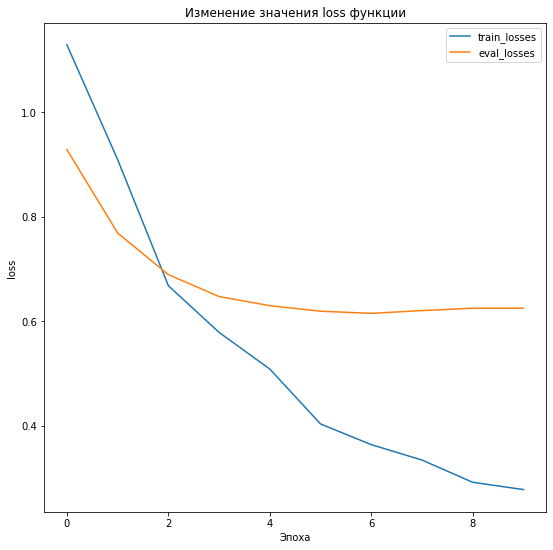

In [5]:
train_losses = [1.1293, 0.9096, 0.6681, 0.5787, 0.5085, 0.4034, 0.3638, 0.3343, 0.2917, 0.2778]
eval_losses = [0.928706, 0.768975, 0.689310, 0.647333, 0.629888, 0.619227, 0.615132, 0.620432, 0.624910, 0.625068]
plt.figure(figsize=(9, 9))
plt.title("Изменение значения loss функции")
plt.xlabel("Эпоха")
plt.ylabel("loss")
plt.plot(train_losses)
plt.plot(eval_losses)
plt.legend(['train_losses', 'eval_losses'])
plt.show()

На графике видно, что значение training loss постоянно снижалось (с 1.13 до 0.28). Однако, validation loss, достигнув значения 0.615, с 7й эпохи начинает увеличиваться, что свидетельствует о переобучении.

# Проверка работоспособности

In [63]:
dataset["text"][0]

'Your passion is permanently etched on my soul, On all flesh, branding skin north and south. Even after I have finished brushing my teeth I can relive your taste in my mouth. Your poems play new chords on the strings of my heart, The mark your smile leaves? I m still guessing! But the magical way you ve touched me from the start Poetry has no way of expressing. Though it s true that we have never met in the flesh And no photograph I ve ever seen. Could it be a connection from many past lives? Just the thought of you makes my world green. The best artist could never capture the beauty Of the truth you have let my heart see, Only one thing could possibly soften this blow: To know that in fact - you are for me.'

In [64]:
text = dataset["text"][0]

encoding = tokenizer(text, return_tensors="pt")
encoding = {k: v.to(trainer.model.device) for k,v in encoding.items()}
outputs = trainer.model(**encoding)
outputs
logits = outputs.logits

In [66]:
# применим sigmoid (для приведения к виду вероятности от 0 до 1) + threshold
sigmoid = torch.nn.Sigmoid()
probs = sigmoid(logits.squeeze().cpu())
print(probs)
predictions = np.zeros(probs.shape)
predictions[np.where(probs >= 0.5)] = 1
# конвертируем предсказанные id's в реальные названия топиков
predicted_labels = [id2label[idx] for idx, label in enumerate(predictions) if label == 1.0]
print(predicted_labels)

tensor([0.9358, 0.0459, 0.1231, 0.0729, 0.1046, 0.2605, 0.1599, 0.0953, 0.0440,
        0.0972, 0.0341, 0.1531, 0.0466, 0.1765, 0.0293, 0.2195, 0.1335, 0.1518,
        0.0820, 0.0724, 0.1002, 0.2250, 0.4950, 0.2662, 0.0383, 0.0451, 0.1064,
        0.1459, 0.0782, 0.0802, 0.0853, 0.0774, 0.0923, 0.0745, 0.0783, 0.0300,
        0.0425, 0.0731, 0.1576, 0.0388, 0.5435, 0.0656, 0.4500, 0.0774, 0.0700,
        0.0684, 0.2115, 0.0412, 0.0155, 0.0382, 0.0357, 0.1487, 0.0616, 0.0256,
        0.0778, 0.0390, 0.0912, 0.0773, 0.0964, 0.0810, 0.1005, 0.1715, 0.0601,
        0.0995, 0.5363, 0.0640, 0.1113, 0.2351, 0.1393, 0.0524, 0.1224, 0.1208,
        0.0444, 0.2239, 0.0191, 0.0863, 0.0292, 0.0711, 0.2361, 0.0498, 0.0644,
        0.0482, 0.3575, 0.0644, 0.0606, 0.0610, 0.0778, 0.1221, 0.0249, 0.2624,
        0.1426, 0.6623, 0.2081, 0.0281, 0.0635, 0.0208, 0.0468, 0.8097, 0.0975,
        0.2090, 0.1292, 0.0298, 0.2301, 0.1136, 0.0883, 0.0357, 0.0349, 0.0249,
        0.1060, 0.1212, 0.1413, 0.0834, 

## Вывод

Таким образом, трансформер - уже собранная нейросеть со своей структурой и слоями, которая может быть быстро переобучена под нужные задачи и входные данные. 